# 03 - Bayesian Hierarchical Modeling

Fit hierarchical model to 911 prices, diagnose, visualize, and predict.

**Inputs:**
- `data/processed/cleaned_listings.parquet`

**Model:**
```
log(price) ~ age + mileage + 
             (1 + age | generation) +  # random intercept + slope
             (1 | trim_tier) +         # collapsed: base, sport, gt, turbo
             (1 | transmission)
```

**Fixes for convergence:**
1. Weakly informative priors on random effect SDs (HalfNormal σ=0.3-0.5)
2. Trim collapsed into 4 tiers (sparse individual levels)
3. Higher target_accept (0.95)

In [1]:
import logging
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from price_analysis.data.cleaning import TRIM_TO_TIER, prepare_model_data
from price_analysis.models import build_model, fit_model, predict_price
from price_analysis.models.hierarchical import (
    DEFAULT_RE_PRIORS,
    check_diagnostics,
    extract_effects,
    format_prediction_summary,
)

logging.basicConfig(level=logging.INFO)
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
# Paths
DATA_DIR = Path("../data")
PROCESSED_PATH = DATA_DIR / "processed" / "cleaned_listings.parquet"

## Load and Prepare Data

In [3]:
df_cleaned = pd.read_parquet(PROCESSED_PATH)
df = prepare_model_data(df_cleaned, group_trims=True, group_trans=True)
print(f"Model data: {len(df)} listings")
print(f"\nTrim tier counts:\n{df['trim_tier'].value_counts()}")
print(f"\nTrans type counts:\n{df['trans_type'].value_counts()}")
display(df.head())

INFO:price_analysis.data.cleaning:Grouped trims into tiers: {'base': 348, 'sport': 285, 'turbo': 204, 'gt': 92}
INFO:price_analysis.data.cleaning:Grouped transmissions into types: {'manual': 648, 'pdk': 190, 'auto': 91}
INFO:price_analysis.data.cleaning:Model-ready dataset: 929 listings (from 1053 cleaned)


Model data: 929 listings

Trim tier counts:
trim_tier
base     348
sport    285
turbo    204
gt        92
Name: count, dtype: int64

Trans type counts:
trans_type
manual    648
pdk       190
auto       91
Name: count, dtype: int64


,listing_url,title_raw,sale_price,sale_date,model_year,generation,trim,transmission,mileage,color,location,sale_year,age,mileage_10k,mileage_scaled,color_category,log_price,is_valid,trim_tier,trans_type
7,https://bringatrailer.com/listing/2020-porsche...,6k-Mile 2020 Porsche 911 Carrera 4S Coupe,137000,2025-12-24,2020,992.1,Carrera 4S,PDK,6000,Aventurine Green Metallic,"Phoenix, Arizona 85018",2025.0,5.0,0.6,-1.14464,standard,11.827736,True,sport,pdk
11,https://bringatrailer.com/listing/2024-porsche...,2024 Porsche 911 GT3 Touring 6-Speed,272000,2025-12-23,2024,992.2,GT3 Touring,Manual,3000,Chalk,"Wellesley, Massachusetts 02482",2025.0,1.0,0.3,-1.223581,special,12.513557,True,gt,manual
12,https://bringatrailer.com/listing/2018-porsche...,Signal Green 2018 Porsche 911 GT2 RS Weissach,531111,2025-12-24,2018,991.2,GT2 RS,PDK,9000,-to-Sample Signal Green,"Naperville, Illinois 60563",2025.0,7.0,0.9,-1.065699,special,13.182726,True,gt,pdk
14,https://bringatrailer.com/listing/2022-porsche...,2022 Porsche 911 Carrera 4 GTS Cabriolet 7-Speed,165000,2025-12-25,2022,992.1,Carrera 4,Manual,13000,Jet Black Metallic,"Hollis, New York 11423",2025.0,3.0,1.3,-0.960444,standard,12.013701,True,base,manual
17,https://bringatrailer.com/listing/2002-porsche...,2002 Porsche 911 Turbo Coupe 6-Speed,69000,2025-12-24,2002,996.2,Turbo,Manual,73000,Guards Red,"Frisco, Texas 75036",2025.0,23.0,7.3,0.618381,special,11.141862,True,turbo,manual


In [4]:
# Store scaling parameters for prediction
MILEAGE_MEAN = df_cleaned["mileage"].mean()
MILEAGE_STD = df_cleaned["mileage"].std()
print(f"Mileage scaling: mean={MILEAGE_MEAN:.0f}, std={MILEAGE_STD:.0f}")

Mileage scaling: mean=49500, std=38003


In [5]:
# Check category levels
print("Generation levels:", df["generation"].cat.categories.tolist())
print("Trim levels:", df["trim"].cat.categories.tolist())
print("Transmission levels:", df["transmission"].cat.categories.tolist())

Generation levels: ['991.1', '991.2', '992.1', '992.2', '996.1', '996.2', '997.1', '997.2']
Trim levels: ['Carrera', 'Carrera 4', 'Carrera 4S', 'Carrera S', 'GT2 RS', 'GT3', 'GT3 RS', 'GT3 Touring', 'Targa', 'Targa 4', 'Targa 4S', 'Turbo', 'Turbo S']
Transmission levels: ['Automatic', 'Manual', 'PDK', 'Tiptronic']


In [6]:
# Model configuration
INCLUDE_SALE_YEAR = False  # Currently all 2025 listings (no variance)
USE_TRIM_TIER = True  # Collapse trims into 4 performance tiers
USE_TRANS_TYPE = True  # Collapse Auto/Tiptronic into 'auto'
TARGET_ACCEPT = 0.95  # Higher acceptance rate to reduce divergences

# Show default priors (can override with custom dict)
print("Default random effect SD priors (HalfNormal sigma):")
for k, v in DEFAULT_RE_PRIORS.items():
    print(f"  {k}: {v}")

Default random effect SD priors (HalfNormal sigma):
  generation_sd: 0.5
  trim_sd: 0.5
  transmission_sd: 0.3
  age_slope_sd: 0.1


In [7]:
model = build_model(
    df,
    include_sale_year=INCLUDE_SALE_YEAR,
    use_trim_tier=USE_TRIM_TIER,
    use_trans_type=USE_TRANS_TYPE,
)
print(model)

INFO:price_analysis.models.hierarchical:Model formula: log_price ~ 1 + age + mileage_scaled + (1 + age | generation) + (1 | trim_tier) + (1 | trans_type)
INFO:price_analysis.models.hierarchical:Built model with 929 observations


       Formula: log_price ~ 1 + age + mileage_scaled + (1 + age | generation) + (1 | trim_tier) + (1 | trans_type)
        Family: gaussian
          Link: mu = identity
  Observations: 929
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 11.0569, sigma: 5.2364)
            age ~ Normal(mu: 0.0, sigma: 0.2817)
            mileage_scaled ~ Normal(mu: 0.0, sigma: 1.972)
        
        Group-level effects
            1|generation ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5))
            age|generation ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.1))
            1|trim_tier ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5))
            1|trans_type ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.7573)


In [8]:
# Fit model (this may take a few minutes)
idata = fit_model(
    model,
    draws=2000,
    tune=1000,
    chains=8,
    cores=8,
    target_accept=TARGET_ACCEPT,
)

INFO:price_analysis.models.hierarchical:Fitting model: 2000 draws, 1000 tune, 8 chains, target_accept=0.95
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma, Intercept, age, mileage_scaled, 1|generation_sigma, 1|generation_offset, age|generation_sigma, age|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset]
INFO:pymc.sampling.mcmc:NUTS: [sigma, Intercept, age, mileage_scaled, 1|generation_sigma, 1|generation_offset, age|generation_sigma, age|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset]


Output()

Sampling 8 chains for 1_000 tune and 2_000 draw iterations (8_000 + 16_000 draws total) took 55 seconds.
INFO:pymc.sampling.mcmc:Sampling 8 chains for 1_000 tune and 2_000 draw iterations (8_000 + 16_000 draws total) took 55 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/opt/homebrew/Caskroom/miniconda/base/envs/price-analysis/lib/python3.12/site-packages/arviz/utils.py:146: UserWarning: Items starting with ~: ['1|', 'age|'] have not been found and will be ignored
  warnings.warn(
INFO:price_analysis.models.hierarchical:Model summary:
                         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
sigma                   0.264  0.006   0.253    0.276      0.000    0.000   
Intercept              12.062  0.304  11.472   12.627      0.003    0.003   
age                    -0.053  0.006  -0.064   -0.041      0.000    0.

## MCMC Diagnostics

Check for convergence issues before interpreting results.

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_69594/3320152081.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


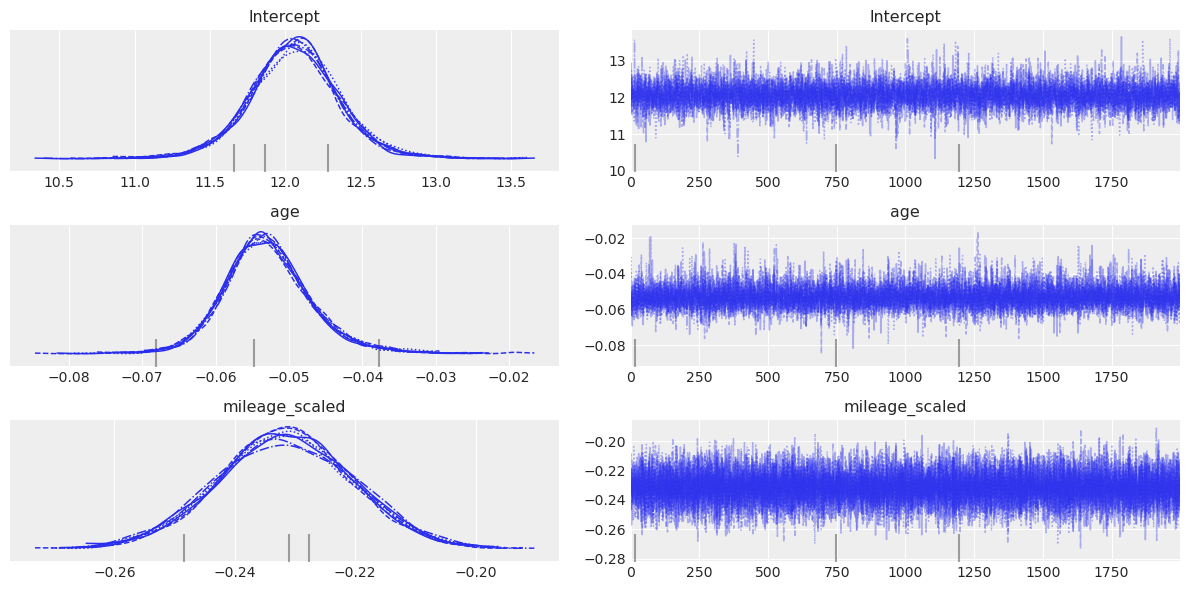

In [9]:
# Trace plots for fixed effects
var_names = ["Intercept", "age", "mileage_scaled"]
if INCLUDE_SALE_YEAR:
    var_names.append("sale_year")
az.plot_trace(idata, var_names=var_names)
plt.tight_layout()
plt.show()

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_69594/3564994746.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


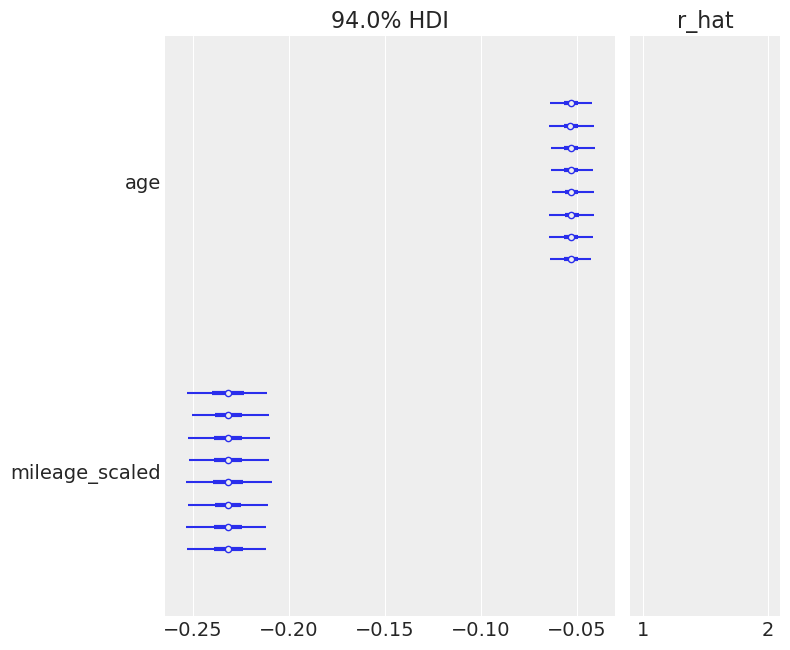

In [24]:
# R-hat summary
az.plot_forest(idata, var_names=["age", "mileage_scaled"], r_hat=True)
plt.tight_layout()
plt.show()

In [26]:

summary = az.summary(idata, var_names=var_names, hdi_prob=0.95)
display(summary)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,12.062,0.304,11.428,12.646,0.003,0.003,7815.0,8953.0,1.0
age,-0.053,0.006,-0.064,-0.040,0.000,0.000,10464.0,9779.0,1.0
mileage_scaled,-0.232,0.011,-0.254,-0.210,0.000,0.000,31898.0,10664.0,1.0


**Interpretation (coefficients are on log-price scale):**

- `age`: Expected change in log(price) per year of age (negative = depreciation)
- `mileage_scaled`: Effect of 1 SD increase in mileage
- `sale_year`: Market trend (positive = prices rising over time) — *excluded when constant*

**Interpretation (coefficients are on log-price scale):**

- `age`: Expected change in log(price) per year of age (negative = depreciation)
- `mileage_scaled`: Effect of 1 SD increase in mileage
- `sale_year`: Market trend (positive = prices rising over time)

## Random Effects

Visualize generation, trim, and transmission effects.

In [13]:
effects = extract_effects(idata)

print("Fixed effects:")
for name, vals in effects["fixed"].items():
    print(f"  {name}: {vals['mean']:.3f} [{vals['hdi_90'][0]:.3f}, {vals['hdi_90'][1]:.3f}]")

Fixed effects:
  Intercept: 12.062 [11.566, 12.540]
  age: -0.053 [-0.063, -0.044]
  mileage_scaled: -0.232 [-0.250, -0.213]


/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_69594/2009308674.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


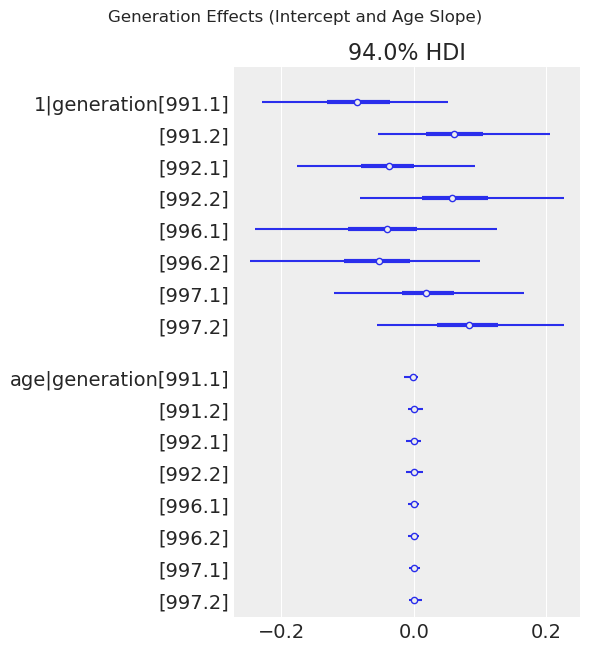

In [14]:
# Forest plot of generation effects
az.plot_forest(idata, var_names=["1|generation", "age|generation"], combined=True)
plt.suptitle("Generation Effects (Intercept and Age Slope)")
plt.tight_layout()
plt.show()

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_69594/1161933721.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


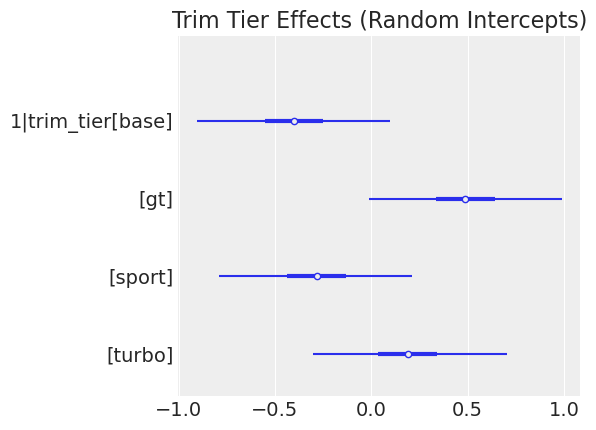

In [15]:
# Forest plot of trim tier effects
az.plot_forest(idata, var_names=["1|trim_tier"], combined=True)
plt.title("Trim Tier Effects (Random Intercepts)")
plt.tight_layout()
plt.show()

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_69594/1451782903.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


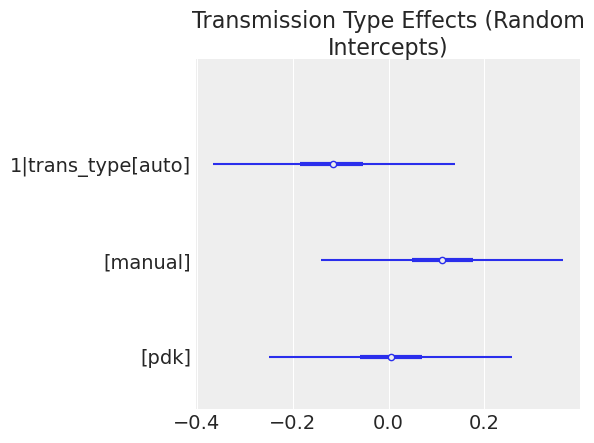

In [16]:
# Forest plot of transmission type effects
az.plot_forest(idata, var_names=["1|trans_type"], combined=True)
plt.title("Transmission Type Effects (Random Intercepts)")
plt.tight_layout()
plt.show()

## Posterior Predictive Checks

How well does the model reproduce the observed data?

In [17]:
# Generate posterior predictive samples
model.predict(idata, kind="pps", inplace=True)

/opt/homebrew/Caskroom/miniconda/base/envs/price-analysis/lib/python3.12/site-packages/bambi/models.py:850: FutureWarning: 'pps' has been replaced by 'response' and is not going to work in the future
  warnings.warn(


/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_69594/1031213045.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


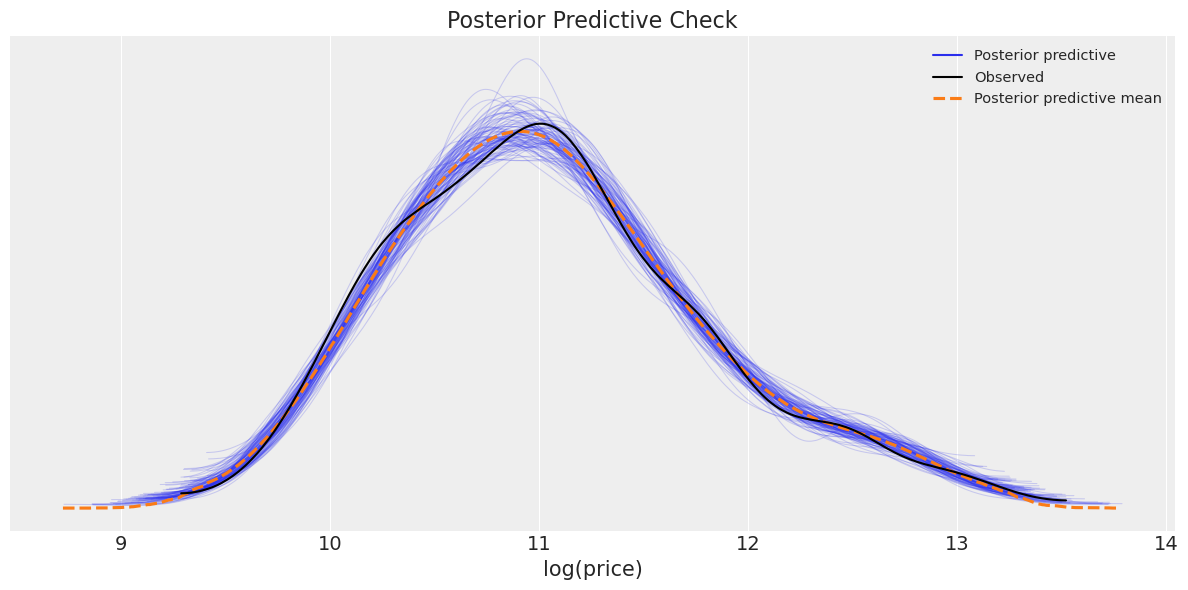

In [18]:
az.plot_ppc(idata, num_pp_samples=100)
plt.title("Posterior Predictive Check")
plt.xlabel("log(price)")
plt.tight_layout()
plt.show()

## Price Predictions

Predict prices for specific configurations.

In [27]:
# Example estimate of price
pred = predict_price(
    model=model,
    idata=idata,
    generation="996.2",
    trim="Carrera 4S",  # for display
    trim_tier="sport",  # model uses tier
    transmission="Manual",  # for display
    trans_type="manual",  # model uses type
    model_year=2002,
    mileage=45000,
    sale_year=2025,
    mileage_mean=MILEAGE_MEAN,
    mileage_std=MILEAGE_STD,
)

print(format_prediction_summary(pred))

Price prediction for:
  2002 996.2 Carrera 4S (Manual)
  Mileage: 45,000 miles
  Sale year: 2025 (age: 23 years)

Predicted price:
  Median: $41,452
  Mean:   $42,872
  80% CI: $29,443 - $58,114
  95% CI: $24,612 - $69,927


/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_69594/4107347789.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


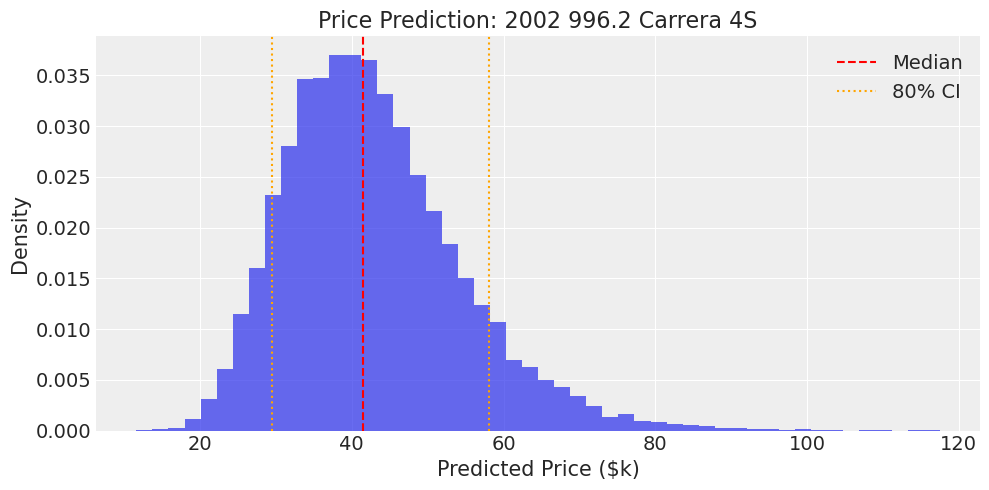

In [28]:
# Visualize prediction distribution
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(pred["samples"] / 1000, bins=50, alpha=0.7, density=True)
ax.axvline(pred["price"]["median"] / 1000, color="red", linestyle="--", label="Median")
ax.axvline(pred["price"]["ci_80"][0] / 1000, color="orange", linestyle=":", label="80% CI")
ax.axvline(pred["price"]["ci_80"][1] / 1000, color="orange", linestyle=":")
ax.set_xlabel("Predicted Price ($k)")
ax.set_ylabel("Density")
ax.set_title(
    f"Price Prediction: {pred['config']['model_year']} {pred['config']['generation']} {pred['config']['trim']}"
)
ax.legend()
plt.tight_layout()
plt.show()

In [29]:
# Compare: Same car but different generation
pred_992 = predict_price(
    model=model,
    idata=idata,
    generation="992.1",
    trim="Carrera 4S",
    trim_tier="sport",
    transmission="PDK",
    trans_type="pdk",
    model_year=2022,
    mileage=45000,
    sale_year=2025,
    mileage_mean=MILEAGE_MEAN,
    mileage_std=MILEAGE_STD,
)

print("996.2 vs 992.1 Carrera 4S comparison:")
print(f"  996.2 (2002, 45k mi, Manual): ${pred['price']['median']:,.0f}")
print(f"  992.1 (2022, 45k mi, PDK):    ${pred_992['price']['median']:,.0f}")

996.2 vs 992.1 Carrera 4S comparison:
  996.2 (2002, 45k mi, Manual): $41,452
  992.1 (2022, 45k mi, PDK):    $110,390


## Depreciation Curves by Generation

Project price trajectories over time.

/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_69594/2747285847.py:44: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


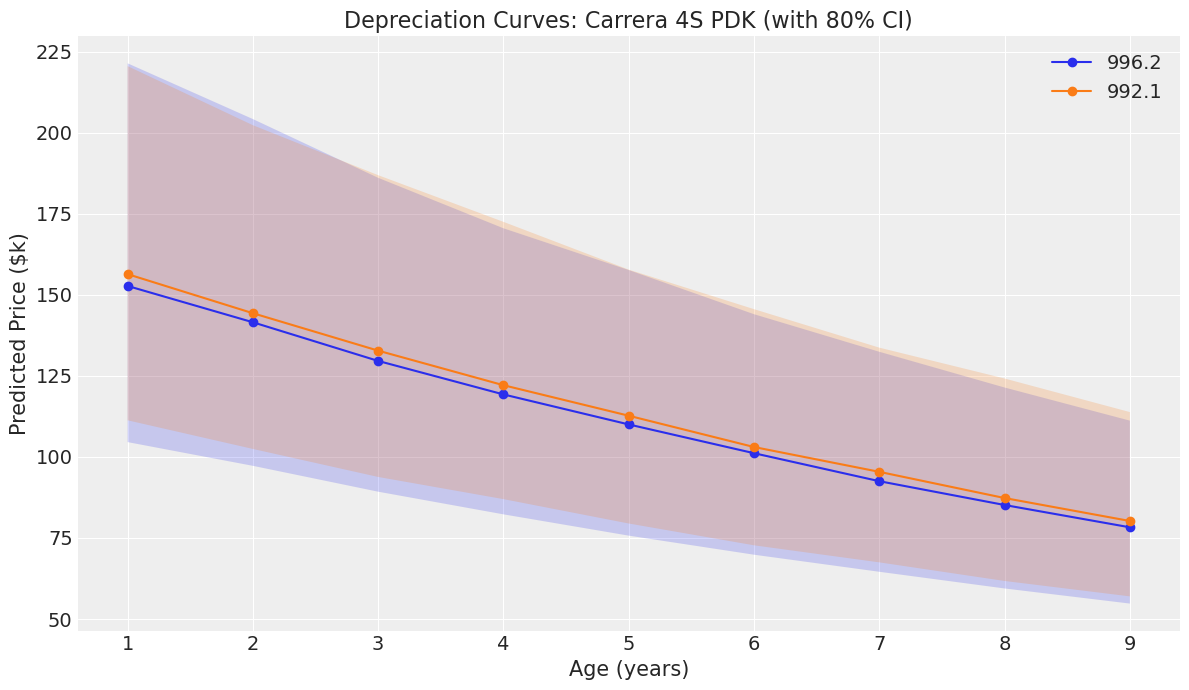

In [22]:
# Project prices for different generations over time
generations = ["996.2", "992.1"]
ages = range(1, 10)
base_year = 2020  # Approximate mid-point for 992.1

fig, ax = plt.subplots(figsize=(12, 7))

for gen in generations:
    medians = []
    ci_lows = []
    ci_highs = []

    for age in ages:
        pred_dep = predict_price(
            model=model,
            idata=idata,
            generation=gen,
            trim="Carrera 4S",
            trim_tier="sport",
            transmission="PDK",
            trans_type="pdk",
            model_year=base_year,
            mileage=5000 * age,  # Assume 5k miles/year
            sale_year=base_year + age,
            mileage_mean=MILEAGE_MEAN,
            mileage_std=MILEAGE_STD,
        )
        medians.append(pred_dep["price"]["median"])
        ci_lows.append(pred_dep["price"]["ci_80"][0])
        ci_highs.append(pred_dep["price"]["ci_80"][1])

    ax.plot(list(ages), [m / 1000 for m in medians], label=gen, marker="o")
    ax.fill_between(
        list(ages),
        [l / 1000 for l in ci_lows],
        [h / 1000 for h in ci_highs],
        alpha=0.2,
    )

ax.set_xlabel("Age (years)")
ax.set_ylabel("Predicted Price ($k)")
ax.set_title("Depreciation Curves: Carrera 4S PDK (with 80% CI)")
ax.legend()
plt.tight_layout()
plt.show()

## Save Model Artifacts

In [23]:
# Save inference data for later use
# idata.to_netcdf(DATA_DIR / "processed" / "model_idata.nc")
# print("Saved inference data")